In [1]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
q0=Z-Ne
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
clight = 299792458.0 # m/s

m_ion = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(q0) # eV/c
gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


/home/pkruyt/cernbox/xsuite-laser/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
SPS_line = xt.Line.from_dict(input_data['line'])

n_part = 30000

# SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=m_ion, q0=q0, p0c=p0c)

nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

SPS_line.particle_ref = particle_sample
twiss = SPS_line.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]



qs=twiss['qs']
bets=twiss['betz0']


#at interaction points:
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101


arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        qs=qs,
        bets=bets
        )


T_per_turn = circumference/(clight*beta)

Loading line from dict:   0%|          | 0/11600 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
# particles = xp.generate_matched_gaussian_bunch(
#         num_particles=n_part,
#         #total_intensity_particles=bunch_intensity,
#         nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
#         #R_matrix=r_matrix,
#         particle_ref=particle_sample,
#         line=SPS_line
#         #,steps_r_matrix=steps_r_matrix
#         )

sigma_x = 1.047e-3 # m
sigma_y = 0.83e-3  # m
sigma_dp = 2e-4 # relative ion momentum spread

particles0 = xp.Particles(_context=context,
        mass0 = m_ion, # eV/c^2
        q0    = Z-Ne,
        p0c   = p0c, # eV
        x     = np.random.normal(scale=sigma_x, size=n_part),
        px    = np.random.normal(scale=1e-5, size=n_part),
        y     = np.random.normal(scale=sigma_y, size=n_part),
        py    = np.random.normal(scale=1e-5, size=n_part),
        zeta  = np.random.normal(scale=sigma_z, size=n_part),
        delta = np.random.normal(scale=sigma_dp, size=n_part)# + 3.0*sigma_dp,
        #zeta  = np.random.uniform(low=-5*sigma_z, high=5*sigma_z, size=n_part),
        #delta = np.random.uniform(low=-5*sigma_dp, high=5*sigma_dp, size=n_part)
        )

particles0 = xp.generate_matched_gaussian_bunch(
        num_particles=n_part,
        #total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        #R_matrix=r_matrix,
        particle_ref=particle_sample,
        line=SPS_line
        #,steps_r_matrix=steps_r_matrix
        )


*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6641e-01
... distance to target bunch length: 7.8199e-02
... distance to target bunch length: -3.6997e-03
... distance to target bunch length: -7.6444e-05
... distance to target bunch length: -2.4567e-08
... distance to target bunch length: 3.0249e-07
--> Bunch length: 0.06299997543345463
--> Emittance: 0.06216653183600112


In [4]:
##################
# Laser Cooler #
##################


#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
# theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
# lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy=5e-3

GF_IP = xt.PulsedLaser(_buffer=buf,
                laser_x=0,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = 76.6e-12, # sec                   
                )



laser_energy_list = np.linspace(0, 20*1e-3, 41) # J
laser_energy_list = np.linspace(0, 100*1e-3, 41) # J
fraction_excited_list = []

for laser_energy in tqdm(laser_energy_list):
        GF_IP.laser_energy=laser_energy
        # particles = xp.generate_matched_gaussian_bunch(
        #  num_particles=n_part,
        #  #total_intensity_particles=bunch_intensity,
        #  nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        #  #R_matrix=r_matrix,
        #  particle_ref=particle_sample,
        #  line=SPS_line
        #  #,steps_r_matrix=steps_r_matrix
        #  )
        sigma_x = 1.047e-3 # m
        sigma_y = 0.83e-3  # m

        particles = xp.Particles(_context=context,
                mass0 = m_ion, # eV/c^2
                q0    = Z-Ne,
                p0c   = p0c, # eV
                x     = np.random.normal(scale=sigma_x, size=n_part),
                px    = np.random.normal(scale=1e-5, size=n_part),
                y     = np.random.normal(scale=sigma_y, size=n_part),
                py    = np.random.normal(scale=1e-5, size=n_part),
                zeta  = np.random.normal(scale=sigma_z, size=n_part),
                delta = np.random.normal(scale=sigma_dp, size=n_part)# + 3.0*sigma_dp,
                #zeta  = np.random.uniform(low=-5*sigma_z, high=5*sigma_z, size=n_part),
                #delta = np.random.uniform(low=-5*sigma_dp, high=5*sigma_dp, size=n_part),
                                       )
       
        
        
        num_turns = int(1e0)
        save_interval = 1
        
        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=n_part)
        
        line = xt.Line(
                elements=[GF_IP,arc])

        line.particle_ref = xp.Particles(mass0=m_ion, q0=q0, p0c=p0c)
        line.build_tracker(_context=context)

        line.track(particles, num_turns=1,
              turn_by_turn_monitor=False)

        # np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta, state=state, time=time,s_per_turn=T_per_turn)
        excited=particles.state==2
        fraction_excited_list.append(sum(excited)/len(excited)*100)



Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1033.33 nm


  0%|          | 0/41 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


  2%|▏         | 1/41 [00:05<03:40,  5.52s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


  5%|▍         | 2/41 [00:10<03:32,  5.45s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


  7%|▋         | 3/41 [00:16<03:28,  5.50s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 10%|▉         | 4/41 [00:22<03:30,  5.68s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 12%|█▏        | 5/41 [00:28<03:34,  5.95s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 15%|█▍        | 6/41 [00:35<03:32,  6.06s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 17%|█▋        | 7/41 [00:41<03:31,  6.23s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 20%|█▉        | 8/41 [00:49<03:37,  6.59s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 22%|██▏       | 9/41 [00:56<03:36,  6.77s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 24%|██▍       | 10/41 [01:02<03:25,  6.63s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 27%|██▋       | 11/41 [01:08<03:10,  6.34s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 29%|██▉       | 12/41 [01:13<02:58,  6.14s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 32%|███▏      | 13/41 [01:19<02:48,  6.03s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 34%|███▍      | 14/41 [01:25<02:40,  5.94s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 37%|███▋      | 15/41 [01:32<02:39,  6.13s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 39%|███▉      | 16/41 [01:37<02:31,  6.07s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 41%|████▏     | 17/41 [01:43<02:23,  5.99s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 44%|████▍     | 18/41 [01:49<02:15,  5.88s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 46%|████▋     | 19/41 [01:54<02:07,  5.78s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 49%|████▉     | 20/41 [02:00<02:00,  5.75s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 51%|█████     | 21/41 [02:06<01:53,  5.70s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 54%|█████▎    | 22/41 [02:11<01:47,  5.66s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 56%|█████▌    | 23/41 [02:17<01:42,  5.69s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 59%|█████▊    | 24/41 [02:22<01:35,  5.60s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 61%|██████    | 25/41 [02:28<01:28,  5.55s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 63%|██████▎   | 26/41 [02:33<01:22,  5.49s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 66%|██████▌   | 27/41 [02:39<01:16,  5.45s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 68%|██████▊   | 28/41 [02:44<01:10,  5.44s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 71%|███████   | 29/41 [02:49<01:05,  5.43s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 73%|███████▎  | 30/41 [02:55<00:59,  5.40s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 76%|███████▌  | 31/41 [03:00<00:53,  5.38s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 78%|███████▊  | 32/41 [03:05<00:48,  5.38s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 80%|████████  | 33/41 [03:11<00:42,  5.36s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 83%|████████▎ | 34/41 [03:16<00:37,  5.37s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 85%|████████▌ | 35/41 [03:21<00:32,  5.35s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 88%|████████▊ | 36/41 [03:27<00:26,  5.37s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 90%|█████████ | 37/41 [03:32<00:21,  5.36s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 93%|█████████▎| 38/41 [03:38<00:16,  5.36s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 95%|█████████▌| 39/41 [03:43<00:10,  5.36s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


 98%|█████████▊| 40/41 [03:48<00:05,  5.39s/it]

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


100%|██████████| 41/41 [03:54<00:00,  5.71s/it]

Done compiling ContextCpu kernels.


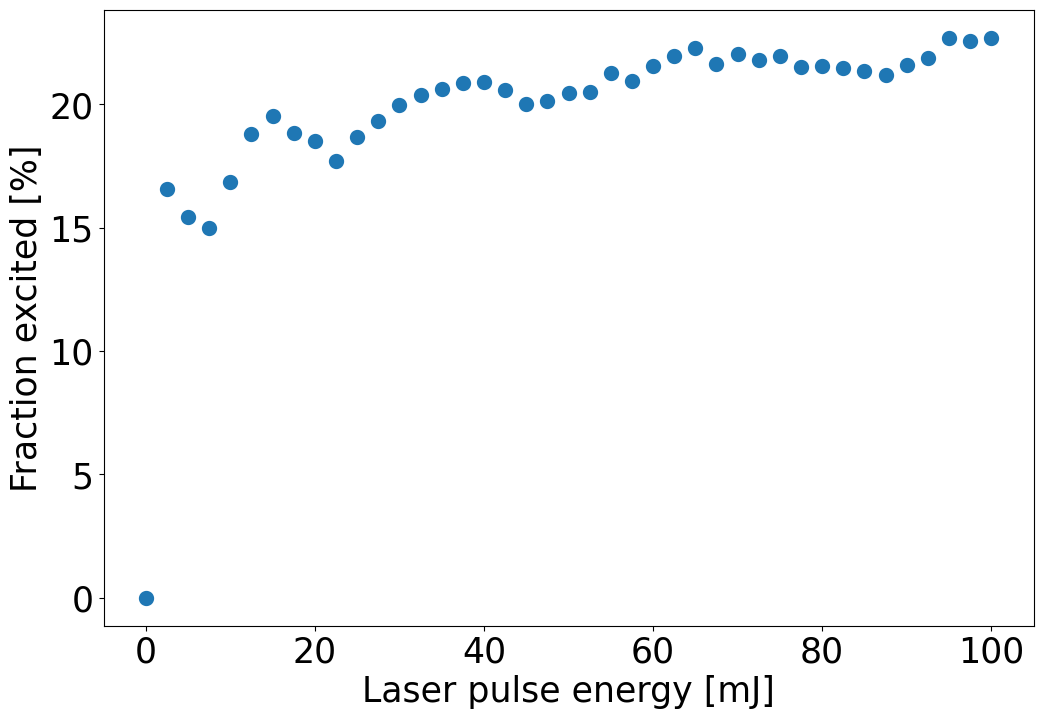

In [5]:
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_energy_list*1e3,fraction_excited_list, label=f'xsuite',color=cmap(0), linewidth=5.0)
plt.xlabel(r'Laser pulse energy [mJ]')
plt.ylabel(r'Fraction excited [%]')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend()
plt.show()

Alexey functions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


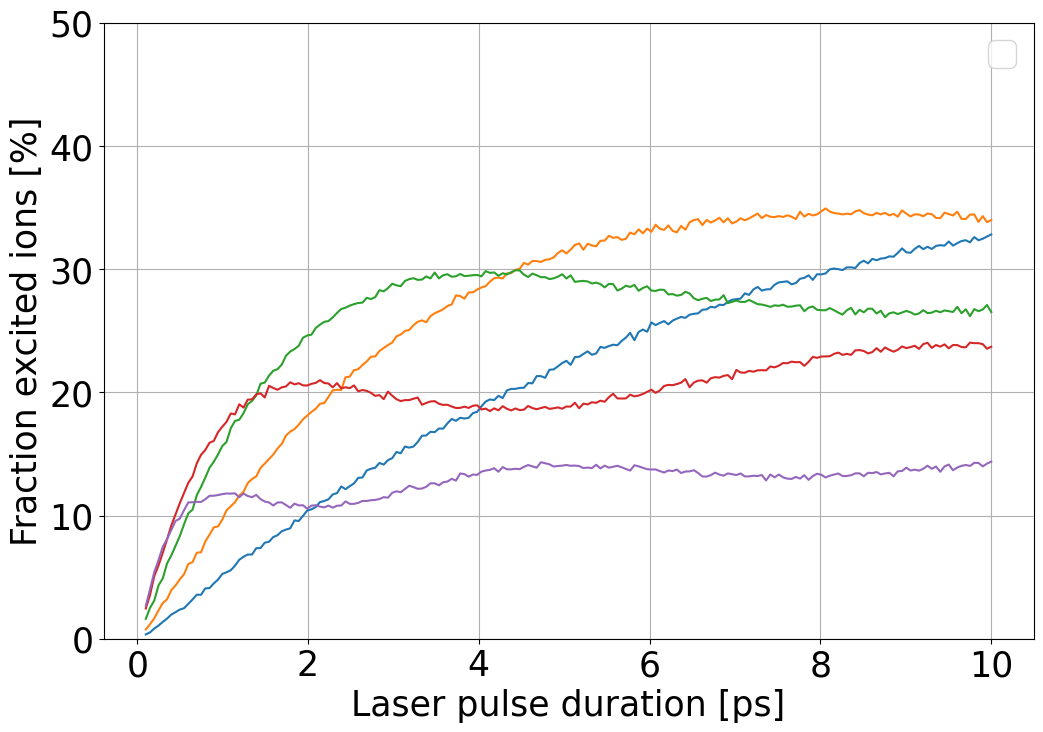

In [6]:
pulse_duration_values = [0.5,1,2,4,8]  # ps
laser_energy_values = np.linspace(0.1,10, 200)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
for duration_ps in pulse_duration_values:
    
    GF_IP.laser_duration_sigma = duration_ps*1e-12
    excitation_values = []

    for laser_energy in laser_energy_values:
        GF_IP.laser_energy = laser_energy*1e-3
        particles = particles0.copy()
        line.track(particles, num_turns=1)

        excited = (particles.state == 2)
        z = particles.zeta
        excitation_values.append(100*len(z[excited])/len(z))
    plt.plot(laser_energy_values,excitation_values)    

plt.xlabel('Laser pulse duration [ps]')    
plt.ylabel('Fraction excited ions [%]')
plt.legend()
plt.grid()
plt.ylim([0,50])
plt.show()

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


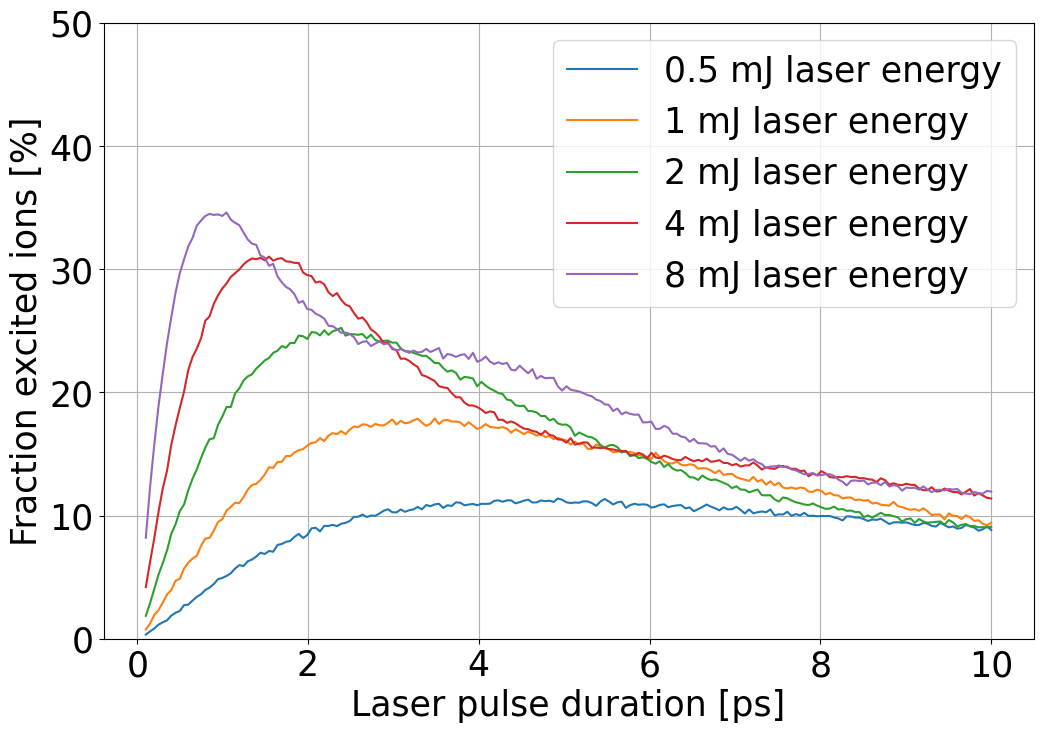

In [7]:
pulse_duration_values = np.linspace(0.1,10, 200) # ps
laser_energy_values = [0.5,1,2,4,8] 

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
for laser_energy in tqdm(laser_energy_values):
    
    GF_IP.laser_energy = laser_energy*1e-3
    excitation_values = []

    for duration_ps in pulse_duration_values:
        GF_IP.laser_duration_sigma = duration_ps*1e-12
        particles = particles0.copy()
        line.track(particles, num_turns=1)

        excited = (particles.state == 2)
        z = particles.zeta
        excitation_values.append(100*len(z[excited])/len(z))
    plt.plot(pulse_duration_values,excitation_values,label=f'{laser_energy} mJ laser energy')    

plt.xlabel('Laser pulse duration [ps]')    
plt.ylabel('Fraction excited ions [%]')
plt.legend()
plt.grid()
plt.ylim([0,50])
plt.show()
